In [1]:
import sys
sys.path.append('../..')
sys.path.append('../../lib/src/')
import torch
from torch import nn
import torch.nn.functional as F
import os
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import logging

from ignite.metrics import SSIM, PSNR




from diffusion.stable_diffusion.latent_diffusion import MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.unet import UNetModel
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

from lib.src.pythae.models import VAE
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.models import LLDM, LVAE_IAF_Config, LVAE_IAF, GPVAE, GPVAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig, BaseTrainer
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs,Encoder_Chairs_GPVAE, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.trainers.training_callbacks import WandbCallback

from geometric_perspective_on_vaes.sampling import hmc_sampling


def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


from matplotlib.patches import Rectangle

def plot_sequence(X, patches=None, edgecolor = 'c'):
    if len(X.shape) == 4:
        X = X.unsqueeze(0)

    X = X.cpu().detach().numpy()
    num_seq = X.shape[0]
    num_obs = X.shape[1]

    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    plt.figure(figsize=(num_obs, num_seq))
    
    for i in range(num_seq):
        for j in range(num_obs):
            ax = plt.subplot(num_seq, num_obs, i * num_obs + j + 1)
            ax.imshow(X[i, j].transpose(1, 2, 0))
            ax.axis('off')
            
            # Add red contour if patches is not None and j is in patches
            if patches is not None and j in patches[i]:
                rect = Rectangle((0.1, 0.1), X[i, j].shape[2]+0.2, X[i, j].shape[1]+0.2, 
                                 linewidth=6, edgecolor=edgecolor, facecolor='none')
                ax.add_patch(rect)
    
    plt.show()
    logger.setLevel(old_level)



%reload_ext autoreload
%autoreload 2

!nvidia-smi

Sun Sep 29 17:14:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   37C    P8             10W /   70W |     119MiB /  12282MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
PATH_DATA = 'my_data/sprites/Sprites_train.pt'


train_data = torch.load(os.path.join(PATH_DATA))[:-1000, :-1, :, :, :]
eval_data = torch.load(os.path.join(PATH_DATA), map_location="cpu")[-1000:, :-1, :, :, :]
test_data = torch.load(os.path.join('my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, :-1, :, :, :]

print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool)
test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=200, shuffle=True)

torch.Size([8000, 7, 64, 64, 3])
torch.Size([8000, 7, 3, 64, 64])


In [3]:
PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-06-16_15-12-03/final_model'
PATH_DIFFUSION_CKPT = 'ldm_retrain/lightning_logs/version_3/checkpoints/epoch=99-step=3200.ckpt'


device = 'cuda'
vae = VAE.load_from_folder(PATH_VAE_FOLDER).to(device)
vae.eval()
#_, _, _ = vae.retrieveG(train_data, verbose = True, T_multiplier=5, device = device, addStdNorm=True)



in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

latent_scaling_factor = 1
n_steps = 1000

#Pas oublier de modif
linear_start =  0.00085
linear_end = 0.012

input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)


latent_diffusion = MyLatentDiffusion(unet, latent_scaling_factor, latent_dim, n_steps, linear_start, linear_end)
print('Number of parameters in the diffusion model: ', sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

model = LitLDM.load_from_checkpoint(PATH_DIFFUSION_CKPT, ldm = latent_diffusion, vae = vae, latent_dim = latent_dim, lr = 6e-4).to(device)
diffusion = model.ldm

Latent dim: 12
Number of parameters in the diffusion model:  2223043


In [5]:
model_config = LVAE_IAF_Config(
    input_dim=(3, 64, 64),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.2,
    n_hidden_in_made=2,
    n_made_blocks=4,
    warmup=0,
    context_dim=None,
    prior='standard',
    posterior='gaussian',
    linear_scheduling_steps=10,

)
training_config = BaseTrainerConfig(
        num_epochs=100,
        learning_rate=1e-4,
        batch_size=256,
        steps_saving=50,
        steps_predict=100,
        shuffle=True,
        output_dir='lldm'
    )


device = 'cuda'
encoder = Encoder_Chairs(model_config).to(device)
decoder = Decoder_Chairs(model_config).to(device)
ddim_sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 1)

temperature = 1


#############
lldm = LLDM(model_config=model_config, encoder=encoder, decoder=decoder, 
                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
                verbose = True, temp = temperature)

lvae = LVAE_IAF.load_from_folder('lldm/LVAE_IAF_training_2024-08-02_14-52-51/final_model').to(device)
gpvae = GPVAE.load_from_folder('dummy_output_dir/GPVAE_training_2024-09-09_19-21-30/final_model').to(device)

lldm.eval()
lvae.eval()
gpvae.eval()

Diffusion time steps  [997 831 665 499 333 167   1]
Running on  cuda:0
Freezing pre-trained VAE and pre-trained LDM...
Freezing done.
Number of trainable parameters: 1.1e+06
Number of total parameters: 4.4e+06


GPVAE(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=12, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )


In [6]:
import torchinfo
print(torchinfo.summary(unet, input_size=(1, 3, 2, 2), cond = None, time_steps = torch.tensor([10])))
print(torchinfo.summary(vae))
print(torchinfo.summary(lldm))

Layer (type:depth-idx)                                       Output Shape              Param #
UNetModel                                                    [1, 3, 2, 2]              --
├─Sequential: 1-1                                            [1, 256]                  --
│    └─Linear: 2-1                                           [1, 256]                  (16,640)
│    └─SiLU: 2-2                                             [1, 256]                  --
│    └─Linear: 2-3                                           [1, 256]                  (65,792)
├─ModuleList: 1-2                                            --                        --
│    └─TimestepEmbedSequential: 2-4                          [1, 64, 2, 2]             --
│    │    └─Conv2d: 3-1                                      [1, 64, 2, 2]             (1,792)
│    └─TimestepEmbedSequential: 2-5                          [1, 64, 2, 2]             --
│    │    └─ResBlock: 3-2                                    [1, 64, 2, 2]    

In [5]:
#lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-07-02_14-46-51/final_model/model.pt')['model_state_dict'])
lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-07-02_18-30-00/final_model/model.pt')['model_state_dict'])

<All keys matched successfully>

In [6]:
def extract_train_embeddings(model, train_data, batch_size = 256):
    train_embeddings = [] 
    #log_vars = []
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=False)
    for i, x in enumerate(train_loader):
        x = x.to('cuda')
        out = model.encoder(x)
        z = out.embedding.reshape(-1, model.n_obs, model.latent_dim)
        log_var = out.log_covariance
        train_embeddings.append(z.cpu().detach())
        #log_vars.append(log_var.cpu().detach())
    train_embeddings = torch.cat(train_embeddings, dim = 0)

    return train_embeddings


def plot_z_seqs(z_seq, train_embeddings):

    num_obs =  NUM_OBS =  train_embeddings.shape[1] 
    pca = PCA(n_components=2)
    n_samples = z_seq.shape[0]
    train_embeddings_pca = pca.fit_transform(train_embeddings.reshape(-1, latent_dim).cpu().detach().numpy()).reshape(-1, num_obs, 2)

    displayed_indexes = range(num_obs)  #range(num_obs)

    all_sequences = z_seq
    all_sequences_pca = pca.transform(all_sequences.reshape(-1, latent_dim).cpu().detach().numpy())
    all_sequences_pca = all_sequences_pca.reshape(n_samples, -1, 2)
    plt.figure(figsize=(NUM_OBS, n_samples))
    plt.scatter(all_sequences_pca[:, :, 0], all_sequences_pca[:, :, 1], s=20, color='purple', label='Samples')
    colors = plt.get_cmap('tab10', num_obs)
    for i in displayed_indexes:
        plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Train obs. {i}')

    for i in range(n_samples):
        plt.plot(all_sequences_pca[i, :, 0], all_sequences_pca[i, :, 1], c = 'purple')


    plt.legend()
    plt.show()


In [6]:
train_embeddings = extract_train_embeddings(lldm, train_data)
train_embeddings_lvae = extract_train_embeddings(lvae, train_data)

print(train_embeddings.shape)
print(train_embeddings_lvae.shape)

torch.Size([8000, 7, 12])
torch.Size([8000, 7, 12])


## Testing reconstruction

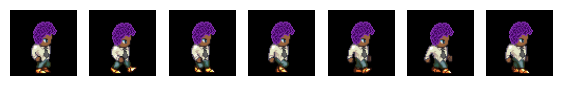

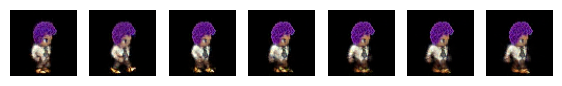

Reconstruction loss LLDM : 25.64095115661621


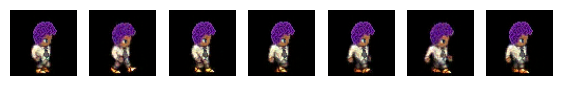

Reconstruction loss LVAE : 12.648488998413086


In [14]:
### TESTING RECONSTRUCTION ###
lldm, lvae = lldm.to('cuda'), lvae.to('cuda')
lldm, lvae = lldm.eval(), lvae.eval()

vi_index = 0

idx = torch.randint(0, len(train_dataset), (1,)).item()
x = train_dataset[idx]



z_seq, x_rec = lldm.reconstruct(x, vi_index = vi_index)
_, x_rec_lvae = lvae.reconstruct(x, vi_index = vi_index)

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec)

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss LLDM :', recon_loss)

plot_sequence(x_rec_lvae)

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec_lvae.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1).cuda(),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss LVAE :', recon_loss)





## Testing generation 
### (without freezing a given obs)

Running Kmedoids
Finding temperature
Best temperature found:  70.64863586425781
Building metric
Increasing T by  1
Sampling 5 points on the 3th/rd manifold...
Batch 1/1
Propagating in the past...
Propagating in the future...
Decoding...


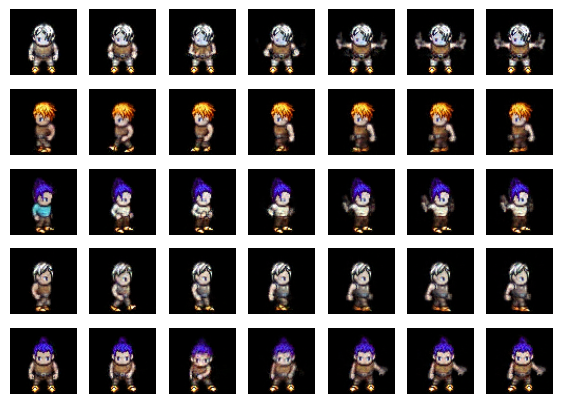

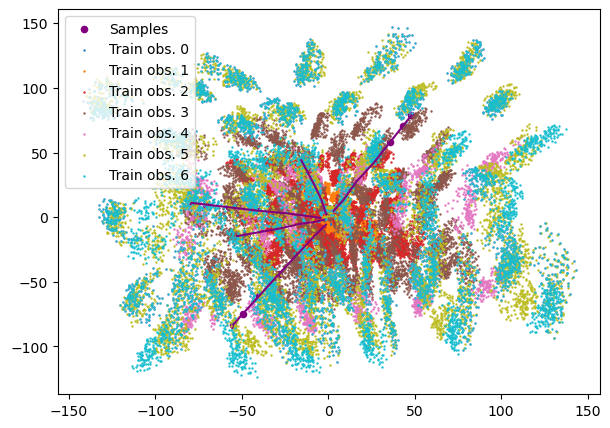

In [16]:
lldm.temperature = 0
recon_x, z_seq = lldm.generate(train_data, num_gen_seq=5, vi_index =3, T_multiplier = 1)
plot_sequence(recon_x)
plot_z_seqs(z_seq, train_embeddings)

## Testing generation 
### (with freezing a given obs)

Running Kmedoids


/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 112 is empty! self.labels_[self.medoid_indices_[112]] may not be labeled with its corresponding cluster (112).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 177 is empty! self.labels_[self.medoid_indices_[177]] may not be labeled with its corresponding cluster (177).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 188 is empty! self.labels_[self.medoid_indices_[188]] may not be labeled with its corresponding cluster (188).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 194 is empty! self.labels_[self.medoid_indices_[194]] ma

Finding temperature
Best temperature found:  2.5649054050445557
Building metric
Increasing T by  0.5
Freezing the 0th/rd obs...
Sampling 1 point on the 0th/rd manifold...


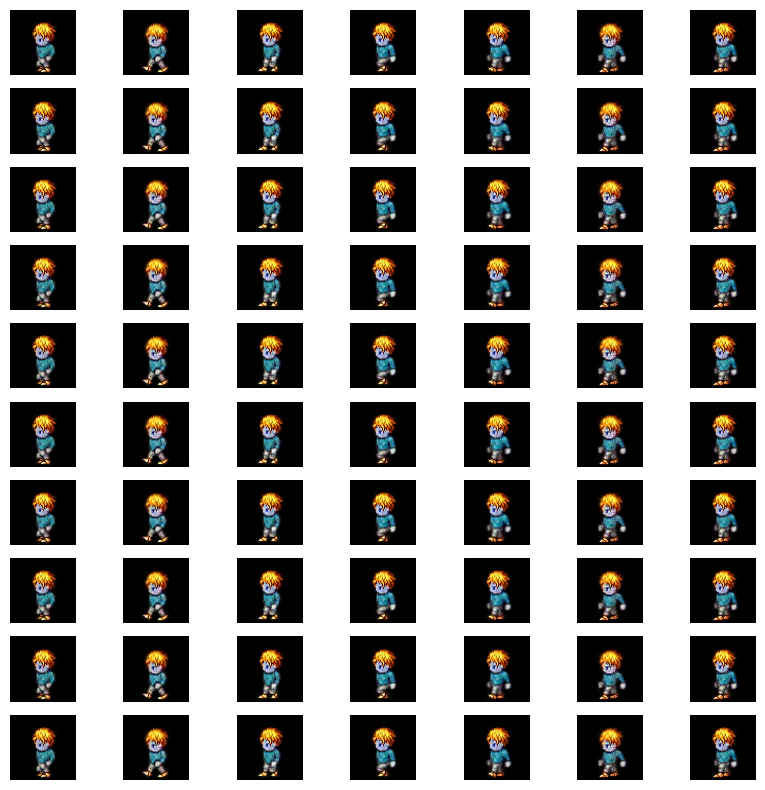

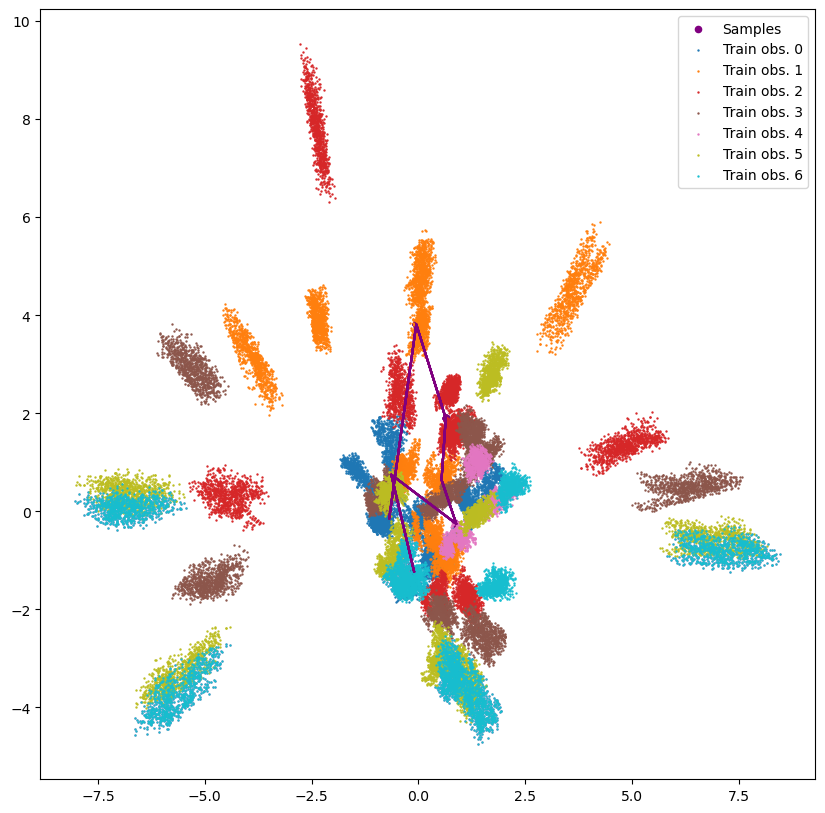

In [28]:
recon_x_lvae, z_seq_lvae = lvae.generate(train_data, num_gen_seq=10, vi_index = 0, freeze = True)
plot_sequence(recon_x_lvae)
plot_z_seqs(z_seq_lvae, train_embeddings_lvae)

Running Kmedoids
Finding temperature
Best temperature found:  70.64863586425781
Building metric
Increasing T by  1
Freezing the 3th/rd obs...
Sampling 1 point on the 3th/rd manifold...
Batch 1/1
Propagating in the past...
Propagating in the future...
Decoding...


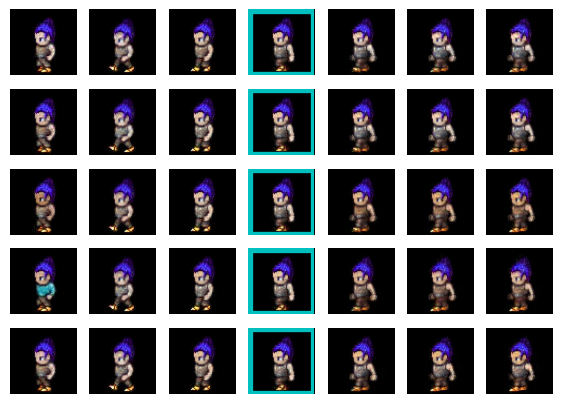

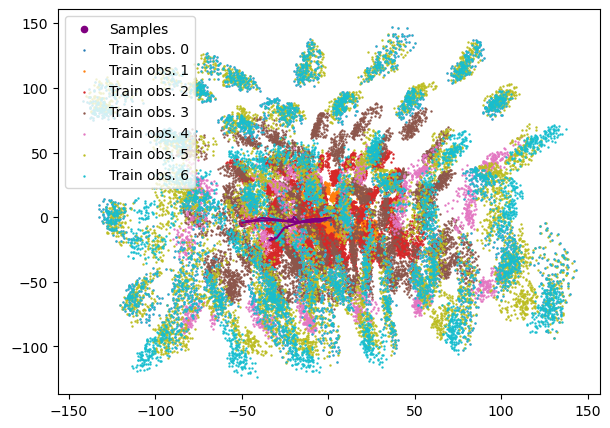

In [32]:
lldm.temperature = 12
num_gen_seq = 5
index = 3

recon_x, z_seq = lldm.generate(train_data, num_gen_seq=num_gen_seq, vi_index =index, T_multiplier = 1, freeze=True)
patches= [[index]]*num_gen_seq
plot_sequence(recon_x, patches)
plot_z_seqs(z_seq, train_embeddings)

In [ ]:
input_dim = (3, 64, 64)
latent_dim = 12
beta = 1
n_hidden_in_made = 3
n_made_blocks = 2
warmup = 5
context_dim = None
prior = 'standard'
posterior = 'gaussian'
vamp_number_components= 500
linear_scheduling_steps = 10
num_epochs = 150
batch_size = 256
learning_rate=  1e-3 
steps_saving = 50
steps_predict = 100
shuffle_data = True
kernel = "cauchy"
out_channels_time_cnn = 265




config = GPVAEConfig(
    input_dim=input_dim,
    time_length=train_data.shape[1],
    kernel_choice=kernel,
    kernel_scales=1,
    latent_dim=latent_dim,
    sigma=1,
    length_scale=1,
    beta=beta,
    out_channels_time_cnn=out_channels_time_cnn
)

training_config = BaseTrainerConfig(
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        batch_size=batch_size,
        steps_saving=steps_saving,
        steps_predict=steps_predict,
        shuffle=shuffle_data
    )

encoder = Encoder_Chairs_GPVAE(config)
decoder = Decoder_Chairs(config)

#model = LVAE_IAF(config, encoder, decoder).to('cuda')
model = GPVAE(config, encoder, decoder).cuda()

### Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=training_config.learning_rate, eps=1e-4)

### Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[50, 100, 125, 150],
    gamma=0.5,
    verbose=True
)

trainer = BaseTrainer(
            model=model,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
        )

trainer.train()

In [26]:
model = model.to('cuda')
model.eval()

from tqdm import tqdm
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

mses = []
for i, x in tqdm(enumerate(test_loader)):
    x.data = x.data.to('cuda')
    x.seq_mask = x.seq_mask.to('cuda')
    x.pix_mask = x.pix_mask.to('cuda')
    recon_x = model(x).recon_x.cpu().detach()
    mse = F.mse_loss(recon_x, x.data.cpu().detach(), reduction="none").mean(dim=(1, 2, 3, 4)).detach().cpu()
    mses.append(mse)

mses = torch.cat(mses)
print('MSE:', mses.mean().item())



84it [00:01, 47.83it/s]

MSE: 0.002033791970461607


## Exploring overfitting

/tmp/ipykernel_4461/3542419053.py:5: UserWarning: Using a target size (torch.Size([7, 3, 64, 64])) that is different to the input size (torch.Size([1, 7, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  dist = F.mse_loss(x, gen)


Distance tensor(0.0045)
Generated...


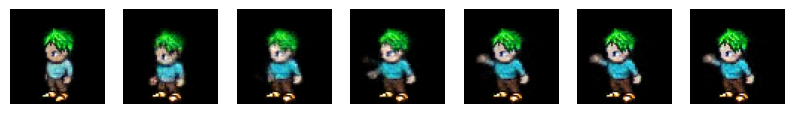

Closest training sample...


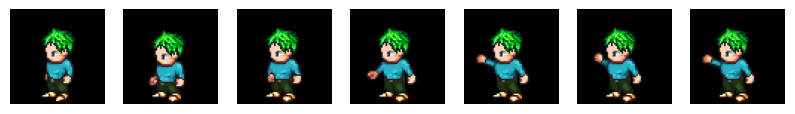

Distance tensor(0.0046)
Generated...


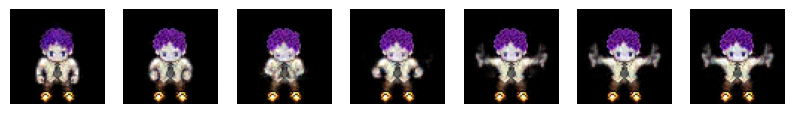

Closest training sample...


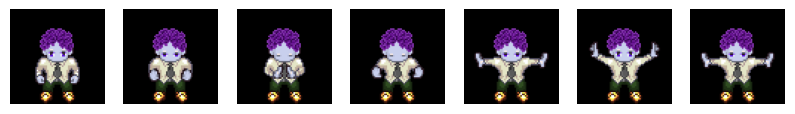

Distance tensor(0.0038)
Generated...


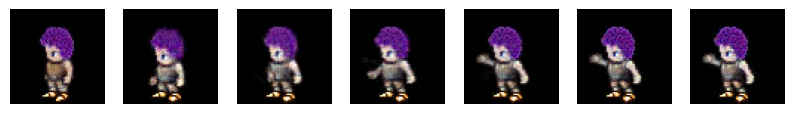

Closest training sample...


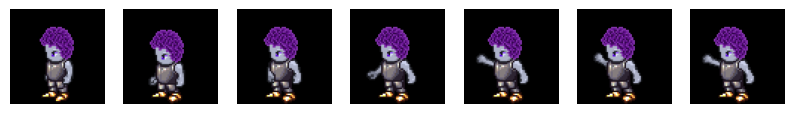

Distance tensor(0.0036)
Generated...


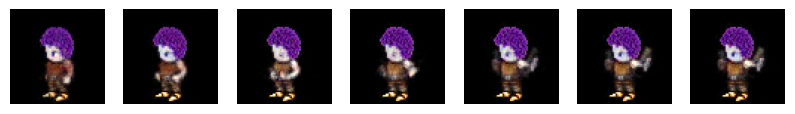

Closest training sample...


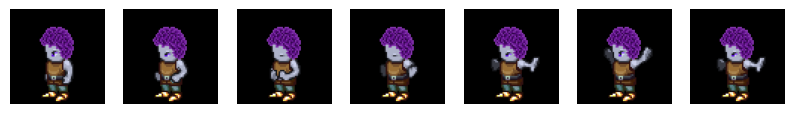

Distance tensor(0.0028)
Generated...


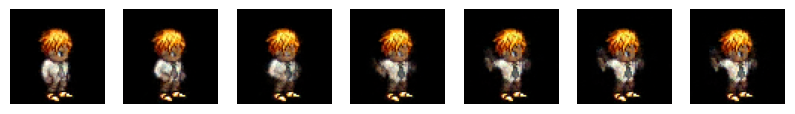

Closest training sample...


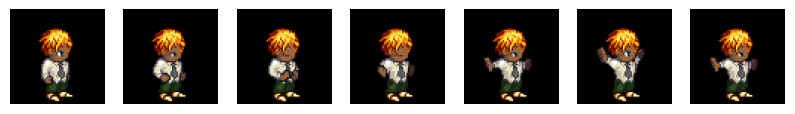

Distance tensor(0.0036)
Generated...


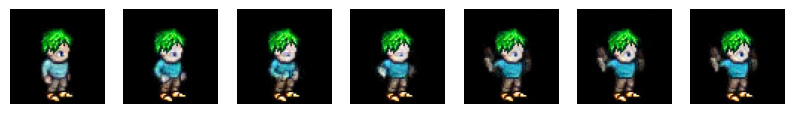

Closest training sample...


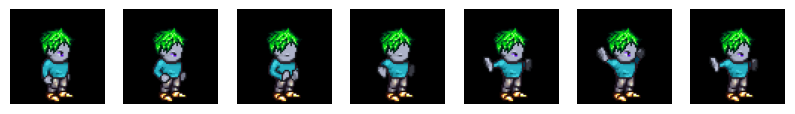

Distance tensor(0.0038)
Generated...


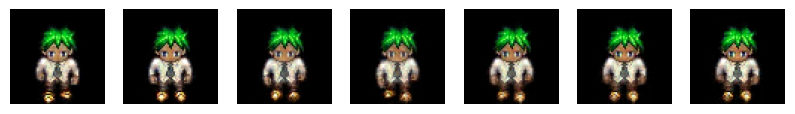

Closest training sample...


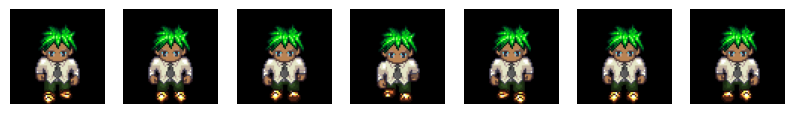

Distance tensor(0.0021)
Generated...


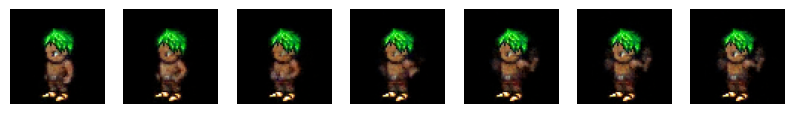

Closest training sample...


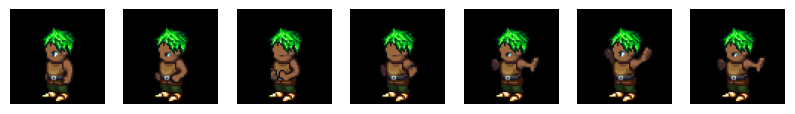

Distance tensor(0.0031)
Generated...


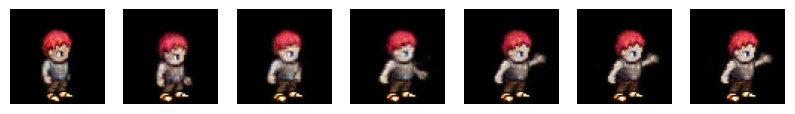

Closest training sample...


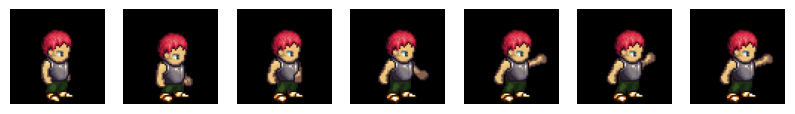

Distance tensor(0.0040)
Generated...


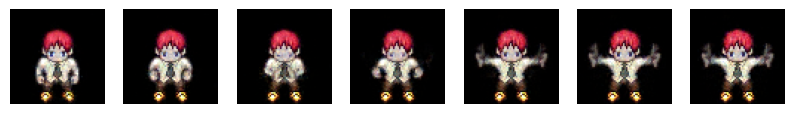

Closest training sample...


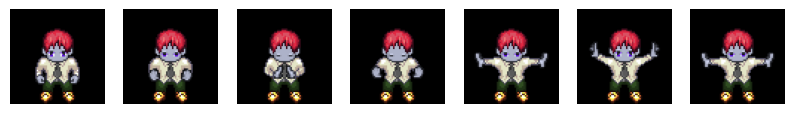

In [33]:
for l in range(recon_x.shape[0]):
    gen = recon_x[l]
    min_dist = torch.inf
    for i, x in enumerate(train_loader):
        dist = F.mse_loss(x, gen)
        if dist < min_dist:
            min_dist = dist
            idx = i
            x_min = x

    print("Distance", min_dist)
    print('Generated...')
    plot_sequence(gen)
    print('Closest training sample...')
    plot_sequence(x_min)

## FID and IS

In [7]:
recon_x, z_seq = lldm.generate(train_data, num_gen_seq=test_data.shape[0], vi_index =3 , T_multiplier = 1, verbose = False, batch_size = 128)
recon_x_lvae, z_seq_lvae = lvae.generate(train_data, num_gen_seq=test_data.shape[0], vi_index = 0, T_multiplier = 1, verbose = True)
print(recon_x.shape)
print(recon_x_lvae.shape)
print(test_data.shape)

Running Kmedoids
Finding temperature
Best temperature found:  2.5649054050445557
Building metric
Increasing T by  1
Sampling 2664 points on the 0th/rd manifold...
Remainder batch size...: size 104
torch.Size([2664, 7, 3, 64, 64])
torch.Size([2664, 7, 3, 64, 64])
torch.Size([2664, 7, 3, 64, 64])


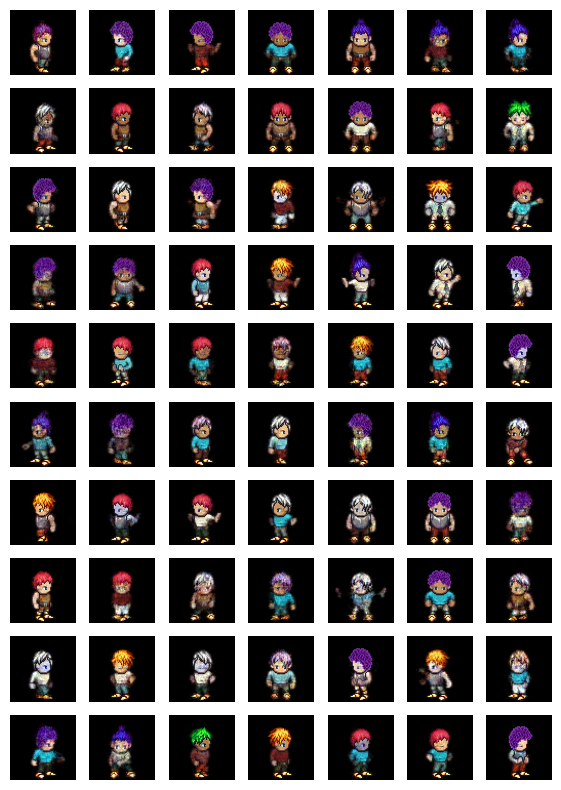

In [13]:
gpvae.time_length = test_data.shape[1]
recon_x_gpvae = gpvae.generate(test_data.shape[0], device = 'cpu')
plot_sequence(recon_x_gpvae[:10])

In [8]:
from torcheval.metrics import FrechetInceptionDistance
from tqdm import tqdm

def compute_fid_with_torcheval(real_images, generated_images, batch_size=256, device='cuda'):
    # Initialize FID metric
    fid_metric = FrechetInceptionDistance().to(device)
    
    def process_in_batches(images, real):
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].to(device)
            fid_metric.update(batch, is_real=real)
            # Clear the batch from memory
            del batch
            torch.cuda.empty_cache()
    
    # Process real images in batches
    process_in_batches(real_images, real=True)
    
    # Process generated images in batches
    process_in_batches(generated_images, real=False)
    
    # Compute the FID score
    fid_score = fid_metric.compute()
    return fid_score



# Example usage:
real_images = test_data.reshape(-1, 3, 64, 64).clamp(0, 1)


In [9]:
all_scores_lldm = []
all_scores_lvae = []
for i in tqdm(range(5)):
    recon_x, z_seq = lldm.generate(train_data, num_gen_seq=test_data.shape[0], vi_index =3 , T_multiplier = 1, verbose = False, batch_size = 128)
    recon_x_lvae, z_seq_lvae = lvae.generate(train_data, num_gen_seq=test_data.shape[0], vi_index = 0, T_multiplier = 1, verbose = False)
    generated_images = recon_x.reshape(-1, 3, 64, 64).clamp(0, 1)
    generated_images_lvae = recon_x_lvae.reshape(-1, 3, 64, 64).clamp(0, 1)
    fid_score = compute_fid_with_torcheval(real_images, generated_images)
    print('FID score LLDM:', fid_score)
    fid_score_lvae = compute_fid_with_torcheval(real_images, generated_images_lvae)
    print('FID score LVAE:', fid_score_lvae)

    all_scores_lldm.append(fid_score.cpu().detach())
    all_scores_lvae.append(fid_score_lvae.cpu().detach())

print('-------------------')
print('Mean FID score LLDM:', np.mean(all_scores_lldm))
print('Mean FID score LVAE:', np.mean(all_scores_lvae))
print('Std FID score LLDM:', np.std(all_scores_lldm))
print('Std FID score LVAE:', np.std(all_scores_lvae))

  0%|          | 0/5 [00:00<?, ?it/s]

Running Kmedoids
Finding temperature
Best temperature found:  2.5649054050445557
Building metric
Increasing T by  1
Sampling 2664 points on the 0th/rd manifold...
Remainder batch size...: size 104
FID score LLDM: tensor(35.9013, device='cuda:0')


 20%|██        | 1/5 [05:17<21:08, 317.06s/it]

FID score LVAE: tensor(51.0009, device='cuda:0')
Running Kmedoids
Finding temperature
Best temperature found:  2.5649054050445557
Building metric
Increasing T by  1
Sampling 2664 points on the 0th/rd manifold...
Remainder batch size...: size 104
FID score LLDM: tensor(36.0911, device='cuda:0')


 40%|████      | 2/5 [09:46<14:27, 289.05s/it]

FID score LVAE: tensor(48.3073, device='cuda:0')
Running Kmedoids
Finding temperature
Best temperature found:  2.5649054050445557
Building metric
Increasing T by  1
Sampling 2664 points on the 0th/rd manifold...
Remainder batch size...: size 104
FID score LLDM: tensor(36.6017, device='cuda:0')


 60%|██████    | 3/5 [14:13<09:17, 278.76s/it]

FID score LVAE: tensor(49.2240, device='cuda:0')
Running Kmedoids
Finding temperature
Best temperature found:  2.5649054050445557
Building metric
Increasing T by  1
Sampling 2664 points on the 0th/rd manifold...
Remainder batch size...: size 104
FID score LLDM: tensor(35.5199, device='cuda:0')


 80%|████████  | 4/5 [18:45<04:36, 276.23s/it]

FID score LVAE: tensor(47.5395, device='cuda:0')
Running Kmedoids
Finding temperature
Best temperature found:  2.5649054050445557
Building metric
Increasing T by  1
Sampling 2664 points on the 0th/rd manifold...
Remainder batch size...: size 104
FID score LLDM: tensor(35.8645, device='cuda:0')


100%|██████████| 5/5 [23:59<00:00, 287.89s/it]

FID score LVAE: tensor(49.2132, device='cuda:0')
-------------------
Mean FID score LLDM: 35.995705
Mean FID score LVAE: 49.056957
Std FID score LLDM: 0.35464624
Std FID score LVAE: 1.157219


In [32]:
all_scores_gpvae = []
for i in tqdm(range(5)):
    recon_x_gpvae = gpvae.generate(test_data.shape[0], device = 'cpu')
    generated_images = recon_x_gpvae.reshape(-1, 3, 64, 64).clamp(0, 1)
    fid_score = compute_fid_with_torcheval(real_images, generated_images, device = 'cuda', batch_size=128)
    print('FID score GPVAE:', fid_score)
    all_scores_gpvae.append(fid_score.cpu().detach())

print('-------------------')
print('Mean FID score GPVAE:', np.mean(all_scores_gpvae))
print('Std FID score GPVAE:', np.std(all_scores_gpvae))

 20%|██        | 1/5 [01:45<07:01, 105.26s/it]

FID score GPVAE: tensor(60.7450, device='cuda:0')


 40%|████      | 2/5 [03:32<05:18, 106.33s/it]

FID score GPVAE: tensor(60.0329, device='cuda:0')


 60%|██████    | 3/5 [05:18<03:32, 106.34s/it]

FID score GPVAE: tensor(60.5244, device='cuda:0')


 80%|████████  | 4/5 [07:05<01:46, 106.43s/it]

FID score GPVAE: tensor(60.0204, device='cuda:0')


100%|██████████| 5/5 [08:51<00:00, 106.38s/it]

FID score GPVAE: tensor(59.8370, device='cuda:0')
-------------------
Mean FID score GPVAE: 60.231934
Std FID score GPVAE: 0.3432667


#### Varying start_index

In [15]:
# Example usage:
real_images = test_data.reshape(-1, 3, 64, 64).clamp(0, 1)


all_scores_lldm = []
all_scores_lvae = []
lldm.temperature = 1
for i in tqdm(range(lldm.n_obs)):
    recon_x, z_seq = lldm.generate(train_data, num_gen_seq=test_data.shape[0], vi_index =i , T_multiplier = 1, verbose = False, batch_size = 128)
    generated_images = recon_x.reshape(-1, 3, 64, 64).clamp(0, 1)
    fid_score = compute_fid_with_torcheval(real_images, generated_images)
    print('Start index :', i)
    print('FID score LLDM:', fid_score)
    all_scores_lldm.append(fid_score.cpu().detach())
    print('-------------------')

 14%|█▍        | 1/7 [02:11<13:11, 131.89s/it]

Start index : 0
FID score LLDM: tensor(49.9954, device='cuda:0')
-------------------


 29%|██▊       | 2/7 [04:24<11:01, 132.22s/it]

Start index : 1
FID score LLDM: tensor(37.2351, device='cuda:0')
-------------------


 43%|████▎     | 3/7 [06:36<08:48, 132.14s/it]

Start index : 2
FID score LLDM: tensor(35.9901, device='cuda:0')
-------------------


 57%|█████▋    | 4/7 [08:48<06:36, 132.28s/it]

Start index : 3
FID score LLDM: tensor(35.6462, device='cuda:0')
-------------------


 71%|███████▏  | 5/7 [11:00<04:24, 132.16s/it]

Start index : 4
FID score LLDM: tensor(36.6955, device='cuda:0')
-------------------


 86%|████████▌ | 6/7 [13:12<02:11, 131.96s/it]

Start index : 5
FID score LLDM: tensor(37.2548, device='cuda:0')
-------------------


100%|██████████| 7/7 [15:24<00:00, 132.01s/it]

Start index : 6
FID score LLDM: tensor(37.6458, device='cuda:0')
-------------------


### IS

In [5]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from scipy.stats import entropy
import numpy as np
from tqdm import tqdm

# Load pre-trained InceptionV3 model
inception_model = inception_v3(pretrained=True, transform_input=True)
inception_model.eval()

def get_inception_score(images, num_splits=10, batch_size=128):
    num_images = images.size(0)
    preds = []

    # Process in batches
    with torch.no_grad():
        for i in range(0, num_images, batch_size):
            batch = images[i:i + batch_size]
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            pred = inception_model(batch)
            preds.append(pred)

    preds = torch.cat(preds, dim=0).cpu().numpy()

    # Calculate the conditional probability
    p_yx = F.softmax(torch.tensor(preds), dim=1).numpy()
    
    # Calculate the marginal probability
    p_y = np.expand_dims(np.mean(p_yx, axis=0), axis=0)
    
    # Calculate the KL divergence for each image
    kl_div = p_yx * (np.log(p_yx + 1e-10) - np.log(p_y + 1e-10))
    kl_div = np.sum(kl_div, axis=1)
    
    # Average the KL divergence over all images
    score = np.mean(np.exp(kl_div))
    
    return score



/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
real_images = test_data.reshape(-1, 3, 64, 64).clamp(0, 1)

lldm.temperature = 1
for i in tqdm(range(3, lldm.n_obs)):
    recon_x, z_seq = lldm.generate(train_data, num_gen_seq=test_data.shape[0], vi_index =i , T_multiplier = 1, verbose = False, batch_size = 128)
    
    generated_images = recon_x.reshape(-1, 3, 64, 64).clamp(0, 1)
    images = generated_images  # Your generated images as a PyTorch tensor of shape (N, 3, H, W)
    score = get_inception_score(images)
    print('Start index :', i)
    print(f"Inception Score LLDM : {score}")
    print('-------------------')


 25%|██▌       | 1/4 [11:25<34:17, 685.78s/it]

Start index : 3
Inception Score LLDM : 2.4623076915740967
-------------------


 50%|█████     | 2/4 [22:47<22:47, 683.52s/it]

Start index : 4
Inception Score LLDM : 2.478290319442749
-------------------


 75%|███████▌  | 3/4 [34:10<11:23, 683.15s/it]

Start index : 5
Inception Score LLDM : 2.4173266887664795
-------------------


100%|██████████| 4/4 [45:31<00:00, 682.86s/it]

Start index : 6
Inception Score LLDM : 2.4673149585723877
-------------------


In [ ]:
real_images = test_data.reshape(-1, 3, 64, 64).clamp(0, 1)

for i in tqdm(range(7)):
    recon_x, z_seq = lldm.generate(train_data, num_gen_seq=test_data.shape[0], vi_index =3 , T_multiplier = 1, verbose = False, batch_size = 128)
    recon_x_lvae, z_seq_lvae = lvae.generate(train_data, num_gen_seq=test_data.shape[0], vi_index = 0, T_multiplier = 1, verbose = False)
    generated_images = recon_x.reshape(-1, 3, 64, 64).clamp(0, 1)
    generated_images_lvae = recon_x_lvae.reshape(-1, 3, 64, 64).clamp(0, 1)
    images = generated_images  # Your generated images as a PyTorch tensor of shape (N, 3, H, W)
    score = get_inception_score(images)
    print(f"Inception Score LLDM : {score}")

    images = generated_images_lvae  # Your generated images as a PyTorch tensor of shape (N, 3, H, W)
    score = get_inception_score(images)
    print(f"Inception Score LVAE: {score}")


In [ ]:
all_scores_gpvae = []
for i in tqdm(range(1)):
    recon_x_gpvae = gpvae.generate(test_data.shape[0], device = 'cpu')
    generated_images = recon_x_gpvae.reshape(-1, 3, 64, 64).clamp(0, 1)
    fid_score = get_inception_score(generated_images)
    print('IS score GPVAE:', fid_score)
    all_scores_gpvae.append(fid_score)

print('-------------------')
print('Mean IS score GPVAE:', np.mean(all_scores_gpvae))
print('Std IS score GPVAE:', np.std(all_scores_gpvae))

## Future prediction

In [6]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)
ssim = SSIM(data_range=1.0)
idx = 1
for i, x in enumerate(test_loader):
    x = x.data.cuda()
    B, T, C, H, W = x.shape
    seq_mask = torch.zeros_like(x)
    seq_mask[:, :-idx] = torch.ones_like(seq_mask[:, :-idx])
    x = x * seq_mask
    encoder_output = gpvae.encoder(x)
    mu, log_var = encoder_output.embedding.reshape(x.shape[0], gpvae.time_length, -1), encoder_output.log_covariance.reshape(x.shape[0], gpvae.time_length, -1)
    qz_x = gpvae.posterior_dist(mean=mu, log_covar=log_var)
    z = qz_x.rsample()
    z = torch.transpose(z, 1, 2)
    pred_x = gpvae.decoder(z.reshape(-1, gpvae.latent_dim))["reconstruction"].reshape(B, T, C, H, W)
    ssim.update(pred_x[:, -1], x[:, -1])

TypeError: SSIM.update() takes 2 positional arguments but 3 were given

In [8]:
from tqdm import tqdm
def compute_pred_metrics(lldm, num_iter = 5):
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

    all_res_ssim = []
    all_res_psnr = []

    for l in range(num_iter):

        res_ssim = torch.zeros((lldm.n_obs-1, lldm.n_obs))
        res_psnr = torch.zeros((lldm.n_obs-1, lldm.n_obs))

        for index in tqdm(reversed(range(lldm.n_obs - 1))):
                
                SSIMS, PSNRS = [], []

                for pos in range(lldm.n_obs - index - 1):
                    SSIMS.append(SSIM(data_range=1.0))
                    PSNRS.append(PSNR(data_range=1.0))

                for i, x in enumerate(test_loader):
                    x = x.to('cuda')
                    B, T, C, H, W = x.shape
                    pred_x = lldm.predict(x, vi_index = index, num_gen_seq=1)
                    pred_x = pred_x.detach().reshape(B, T-index-1, C, H, W)
                    orig = x[:, -pred_x.shape[1]:].detach()

                    for pos in range(lldm.n_obs - index - 1):
                        SSIMS[pos].update((pred_x[:, pos].reshape(-1, 3, 64, 64), orig[:, pos].reshape(-1, 3, 64, 64)))
                        PSNRS[pos].update((pred_x[:, pos].reshape(-1, 3, 64, 64), orig[:, pos].reshape(-1, 3, 64, 64)))

                for pos in range(lldm.n_obs - index - 1):
                    res_ssim[lldm.n_obs - index - 2, lldm.n_obs - pos - 1] = SSIMS[pos].compute()
                    res_psnr[lldm.n_obs - index - 2, lldm.n_obs - pos - 1] = PSNRS[pos].compute()
                    SSIMS[pos].reset()
                    PSNRS[pos].reset() 
        all_res_ssim.append(res_ssim)
        all_res_psnr.append(res_psnr)


    print('---------SSIM---------')
    print(torch.mean(torch.stack(all_res_ssim), dim=0))
    print(torch.std(torch.stack(all_res_ssim), dim=0))
    print('---------PSNR---------')
    print(torch.mean(torch.stack(all_res_psnr), dim=0))
    print(torch.std(torch.stack(all_res_psnr), dim=0))

    return all_res_ssim, all_res_psnr

6it [00:00, 15.45it/s]


torch.Size([6, 6, 3, 64, 64])


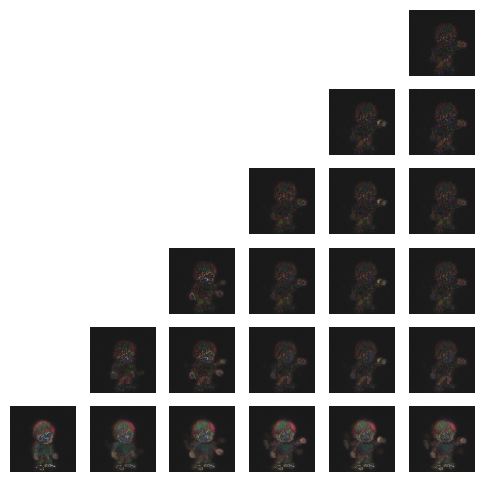

In [87]:
lldm = lldm.to('cuda')
lldm = lldm.eval()
lldm.temperature = 6
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
num_gen_seq = 10
x = test_data[242].unsqueeze(0)

all_completed_x = []
with torch.no_grad():
    for index in tqdm(reversed(range(lldm.n_obs - 1))):
            x = x.to('cuda')
            B, T, C, H, W = x.shape
            pred_x = lldm.predict(x, vi_index = index, num_gen_seq=num_gen_seq) # (B, num_gen_seq, T-index-1, C, H, W)
            
            orig = x[:, -pred_x.shape[2]:].detach().reshape(B, -1, C, H, W).unsqueeze(1).repeat(1, num_gen_seq, 1, 1, 1, 1)
            diff = torch.abs(pred_x - orig).mean(dim = 1)
            #diff = ((pred_x - orig)**2).mean(dim = 1)
            completed_x = torch.cat([torch.ones_like(x[:, 1:index+1]), diff], dim=1)
            all_completed_x.append(completed_x)

all_completed_x = torch.stack(all_completed_x, dim=0).squeeze(1)
print(all_completed_x.shape)
plot_sequence(all_completed_x + 0.1)

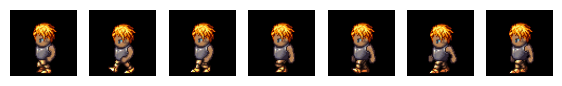

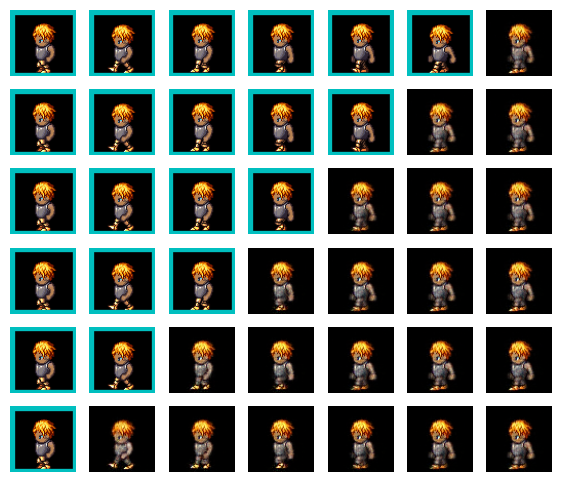

In [21]:
#x = test_data[242]
x = test_data[652]
lldm.temperature = 1
num_gen_seq = 1


plot_sequence(x)
all_completed_x = []
patches = []
for index in reversed(range(lldm.n_obs - 1)):

    neg_pos = index + 1 - lldm.n_obs
    length_seq = lldm.n_obs - index - 1

    pred_x= lldm.predict(x, vi_index = index, num_gen_seq= num_gen_seq )
    pred_x = pred_x.squeeze(1).cpu().detach()
    completed_x = torch.cat([x[:index+1], pred_x.squeeze(0)], dim=0)
    all_completed_x.append(completed_x)
    patches.append(range(index+1))

all_completed_x = torch.stack(all_completed_x, dim=0)
plot_sequence(all_completed_x, patches)

In [52]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)
lldm.temperature = 1
num_gen_seq = 10

res = {'6': [], '5': [], '4': [], '3': [], '2': [], '1': []}
res_std = {'6': [], '5': [], '4': [], '3': [], '2': [], '1': []}

for index in reversed(range(lldm.n_obs - 1)):
    for i, x in enumerate(test_loader):
        x = x.to('cuda')
        B, T, C, H, W = x.shape
        pred_x = lldm.predict(x, vi_index = index, num_gen_seq=num_gen_seq)
        pred_x = pred_x.squeeze(1).cpu().detach().reshape(B, num_gen_seq, T-index-1, C, H, W)
        orig = x[:, -pred_x.shape[2]:].unsqueeze(1).cpu().detach()
        mse = F.mse_loss(pred_x, orig, reduction='none').sum(dim=(3, 4, 5))
        std_mc = mse.std(dim = 1).mean(dim=0)
        mse = mse.min(dim=1)[0].mean(dim=0) #mean over batch and MC samples. Final size = len(pred)
        res[str(index+1)] = [0]*(index+1) + [np.round(mse[i].item(),2) for i in range(mse.shape[0])]
        res_std[str(index+1)] = [0]*(index+1) + [np.round(std_mc[i].item(),3) for i in range(std_mc.shape[0])]
    
print(res)
print(res_std)

/tmp/ipykernel_1906298/670049624.py:15: UserWarning: Using a target size (torch.Size([128, 1, 1, 3, 64, 64])) that is different to the input size (torch.Size([128, 10, 1, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(pred_x, orig, reduction='none').sum(dim=(3, 4, 5))
/tmp/ipykernel_1906298/670049624.py:15: UserWarning: Using a target size (torch.Size([104, 1, 1, 3, 64, 64])) that is different to the input size (torch.Size([104, 10, 1, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(pred_x, orig, reduction='none').sum(dim=(3, 4, 5))
/tmp/ipykernel_1906298/670049624.py:15: UserWarning: Using a target size (torch.Size([128, 1, 2, 3, 64, 64])) that is different to the input size (torch.Size([128, 10, 2, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same si

{'6': [0, 0, 0, 0, 0, 0, 42.21], '5': [0, 0, 0, 0, 0, 67.55, 43.93], '4': [0, 0, 0, 0, 40.39, 64.49, 42.28], '3': [0, 0, 0, 48.93, 40.07, 64.3, 42.05], '2': [0, 0, 41.01, 48.83, 40.16, 64.18, 42.01], '1': [0, 51.46, 56.14, 65.2, 63.98, 85.56, 63.4]}
{'6': [0, 0, 0, 0, 0, 0, 0.013], '5': [0, 0, 0, 0, 0, 0.174, 0.132], '4': [0, 0, 0, 0, 0.342, 0.306, 0.268], '3': [0, 0, 0, 0.572, 0.722, 0.58, 0.504], '2': [0, 0, 0.764, 1.466, 1.487, 1.268, 1.08], '1': [0, 6.742, 8.768, 10.552, 13.883, 13.595, 14.225]}


/tmp/ipykernel_1906298/670049624.py:15: UserWarning: Using a target size (torch.Size([104, 1, 6, 3, 64, 64])) that is different to the input size (torch.Size([104, 10, 6, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(pred_x, orig, reduction='none').sum(dim=(3, 4, 5))


In [109]:
print('---------LVAE---------')
all_res_ssim_lvae, all_res_psnr_lvae = compute_pred_metrics(lvae, num_iter = 5)

---------LVAE---------


6it [00:08,  1.39s/it]
6it [00:08,  1.38s/it]
6it [00:08,  1.39s/it]
6it [00:08,  1.38s/it]
6it [00:08,  1.38s/it]

---------SSIM---------
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9401],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9401, 0.9342],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.9400, 0.9340, 0.9399],
        [0.0000, 0.0000, 0.0000, 0.9399, 0.9340, 0.9399, 0.9279],
        [0.0000, 0.0000, 0.9398, 0.9340, 0.9398, 0.9280, 0.9298],
        [0.0000, 0.8938, 0.8879, 0.8937, 0.8946, 0.9058, 0.9099]])
tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])
---------PSNR---------
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 28.0048],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 28.0257, 27.2567],
        [ 0.0000,  0.0000,  0.0000,  0.0000, 27.9900, 27.2206, 27.9654],
        [ 0.0000,  0.0000,  0.0000, 27.9745, 27.2088, 27.9491, 26.8421],
        [ 0.0000,  0.0000, 27.9640, 

In [111]:
lldm.temperature = 0
lldm.ddim_sampler = DDIMSampler(lldm.pretrained_ldm, n_steps = lldm.n_obs-1, ddim_eta = 0)
print('---------LLDM---------')
all_res_ssim_lldm, all_res_psnr_lldm = compute_pred_metrics(lldm, num_iter = 1)


---------LLDM---------


6it [00:23,  3.96s/it]

---------SSIM---------
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8938],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8823, 0.8653],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.8918, 0.8736, 0.9024],
        [0.0000, 0.0000, 0.0000, 0.8924, 0.8738, 0.9025, 0.8918],
        [0.0000, 0.0000, 0.8933, 0.8742, 0.9029, 0.8930, 0.9107],
        [0.0000, 0.8524, 0.8340, 0.8582, 0.8671, 0.8883, 0.8956]])
tensor([[nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan]])
---------PSNR---------
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 24.7255],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 24.5021, 22.7928],
        [ 0.0000,  0.0000,  0.0000,  0.0000, 24.6762, 22.9941, 24.8727],
        [ 0.0000,  0.0000,  0.0000, 24.6883, 22.9898, 24.8647, 24.4


/tmp/ipykernel_1906298/2189866460.py:43: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  print(torch.std(torch.stack(all_res_ssim), dim=0))
/tmp/ipykernel_1906298/2189866460.py:46: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  print(torch.std(torch.stack(all_res_psnr), dim=0))


652


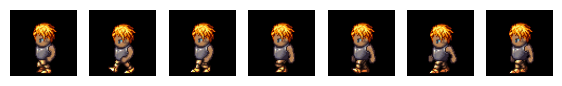

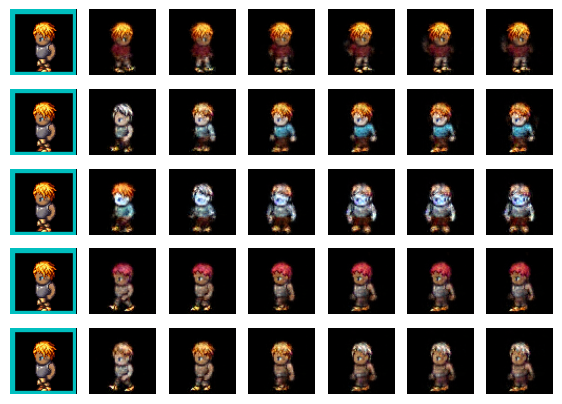

torch.Size([7, 3, 64, 64])
----SSIM----
tensor([[0.7307, 0.7384, 0.7087, 0.6855, 0.6626, 0.6736],
        [0.8212, 0.8133, 0.8093, 0.8199, 0.7878, 0.8019],
        [0.7984, 0.7477, 0.7038, 0.6990, 0.7116, 0.6960],
        [0.8653, 0.8650, 0.8636, 0.8334, 0.8235, 0.8347],
        [0.8783, 0.9145, 0.8801, 0.8222, 0.8117, 0.8119]])
----PSNR----
tensor([[17.2273, 17.6142, 17.4099, 17.3309, 17.0849, 17.3586],
        [17.7077, 18.3804, 19.4979, 19.7235, 19.0109, 19.8359],
        [17.9109, 16.0630, 15.7425, 15.3788, 15.7463, 15.5704],
        [20.2911, 19.7318, 20.7386, 20.1382, 19.8713, 20.3672],
        [20.9381, 23.4664, 22.4955, 19.4628, 19.3765, 19.5419]])


In [28]:
#idx = torch.randint(0, len(test_data), (1,)).item()
idx = 652
print(idx)
x = test_data[idx]
lldm.temperature = 5
index = 0
num_gen_seq = 5
neg_pos = index + 1 - lldm.n_obs
length_seq = lldm.n_obs - index - 1



full_x = lldm.predict(x, vi_index = index, num_gen_seq= num_gen_seq )

plot_sequence(x)

all_completed_x = []
patches = []
for j in range(num_gen_seq):
    pred_x = full_x.squeeze(0)[j].cpu().detach()
    completed_x = torch.cat([x[:index+1], pred_x], dim=0)
    all_completed_x.append(completed_x)
    patches.append(range(index+1))

all_completed_x = torch.stack(all_completed_x, dim=0)
plot_sequence(all_completed_x, patches)


print(x.shape)
pred = full_x.reshape(1, num_gen_seq, length_seq, -1).cpu().clamp(0,1)
orig = x.unsqueeze(0)[:, neg_pos:].reshape(1, 1, length_seq, -1).clamp(0,1)
#orig = orig.repeat(1, num_gen_seq, 1, 1)

ssim = SSIM(data_range=1.0)
psnr = PSNR(data_range=1.0)
all_ssims = []
all_psnrs = []
for pos in range(orig.shape[2]):
    ssims = []
    psnrs = []
    for l in range(num_gen_seq):
        ssim.update((pred[:, l, pos].reshape(-1, 3, 64, 64), orig[:, :, pos].reshape(-1, 3, 64, 64)))
        ssims.append(ssim.compute())
        ssim.reset()

        psnr.update((pred[:, l, pos].reshape(-1, 3, 64, 64), orig[:, :, pos].reshape(-1, 3, 64, 64)))
        psnrs.append(psnr.compute())
        psnr.reset()

    all_ssims.append(ssims)
    all_psnrs.append(psnrs)

print('----SSIM----')
print(torch.tensor(all_ssims).T)
print('----PSNR----')
print(torch.tensor(all_psnrs).T)

In [ ]:
from tqdm import tqdm


lldm.temperature = 0
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
num_gen_seq = 10

loop_range = range(lldm.n_obs -1)


all_mses = []
for vi_index in loop_range:
    neg_pos = vi_index + 1 - lldm.n_obs
    length_seq = lldm.n_obs - vi_index - 1

    mses = []
    mc_stds = []
    for i, x in tqdm(enumerate(test_loader)):
        x = x.to('cuda')
        batch_size = x.shape[0]
        full_x = lldm.predict(x, vi_index = vi_index, num_gen_seq= num_gen_seq) #(B, num_gen, T, C, H, W)

        pred = full_x.reshape(batch_size, num_gen_seq, length_seq, -1)
        orig = x[:, neg_pos:].reshape(batch_size, 1, length_seq, -1)

        mse = nn.MSELoss(reduction = 'none')(orig, pred).cpu().detach()
        mse = mse.sum(dim = -1) #Sum over all pixels
        mse = mse.mean(dim = -1) #Mean over all time steps
        #mse = mse.mean(dim = -1) #Mean over all generated sequences

        #mse = mse.mean(dim = -2) #Mean over batch

        mses.append(mse)

    mses = torch.cat(mses).reshape(-1, num_gen_seq) # (len(test_data), num_gen_seq)
    all_mses.append(mses)

all_mses = torch.stack(all_mses, dim = 0) # (n_obs -1, len(test_data), num_gen_seq)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor([75.7417, 48.7604, 50.0150, 50.2099, 57.1483, 42.7068])


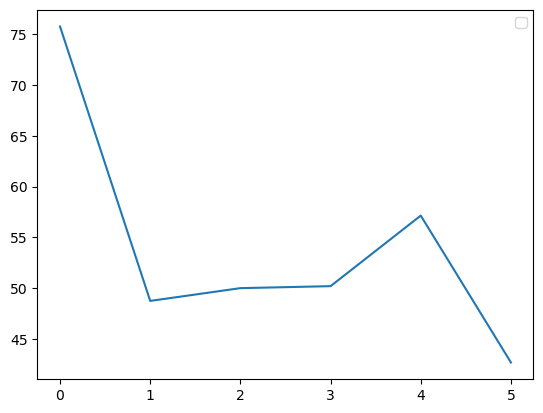

In [70]:
plot, _ = all_mses.mean(dim = 1).min(dim = - 1)
print(plot)
#std = all_mses.mean(dim = 1).std(dim = - 1)
plt.plot(plot)
#plt.fill_between(range(len(plot)), plot - std, plot + std, alpha=0.3)
plt.legend()
plt.show()

## Oversampling

### Reconstruction

997
Updating the DDIM sampler...
Previous diffusion timeline:  [997 831 665 499 333 167   1]
New diffusion timeline:  [997 914 831 748 665 582 499 416 333 250 167  84   1]


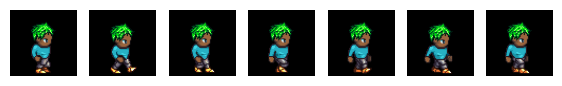

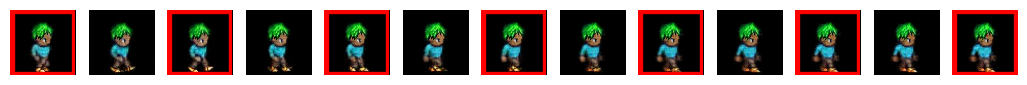

In [78]:
idx = torch.randint(0, len(test_data), (1,)).item()
idx = 997
print(idx)
x = train_dataset[idx]

time_steps = np.sort([997, 831, 665, 499, 333, 167,   1] + [914, 748, 582, 416, 250, 84])
sampler = DDIMSampler(diffusion, time_steps=time_steps, ddim_eta=1)

lldm.temperature = 0.1


z_seq, recon_x = lldm.oversample(x, vi_index = 3, sampler = sampler, verbose = True)

plot_sequence(x.data)
plot_sequence(recon_x, patches = [[i for i in range(0,len(time_steps),2)]], edgecolor='r')

### Generation

Diffusion time steps  [997 914 831 748 665 560 499 416 333 250 167  84   1]
Running Kmedoids
Finding temperature
Best temperature found:  8.50917911529541
Building metric
Increasing T by  1
Sampling 15 points on the 0th/rd manifold...
Batch 1/1
Propagating in the future...
Decoding...


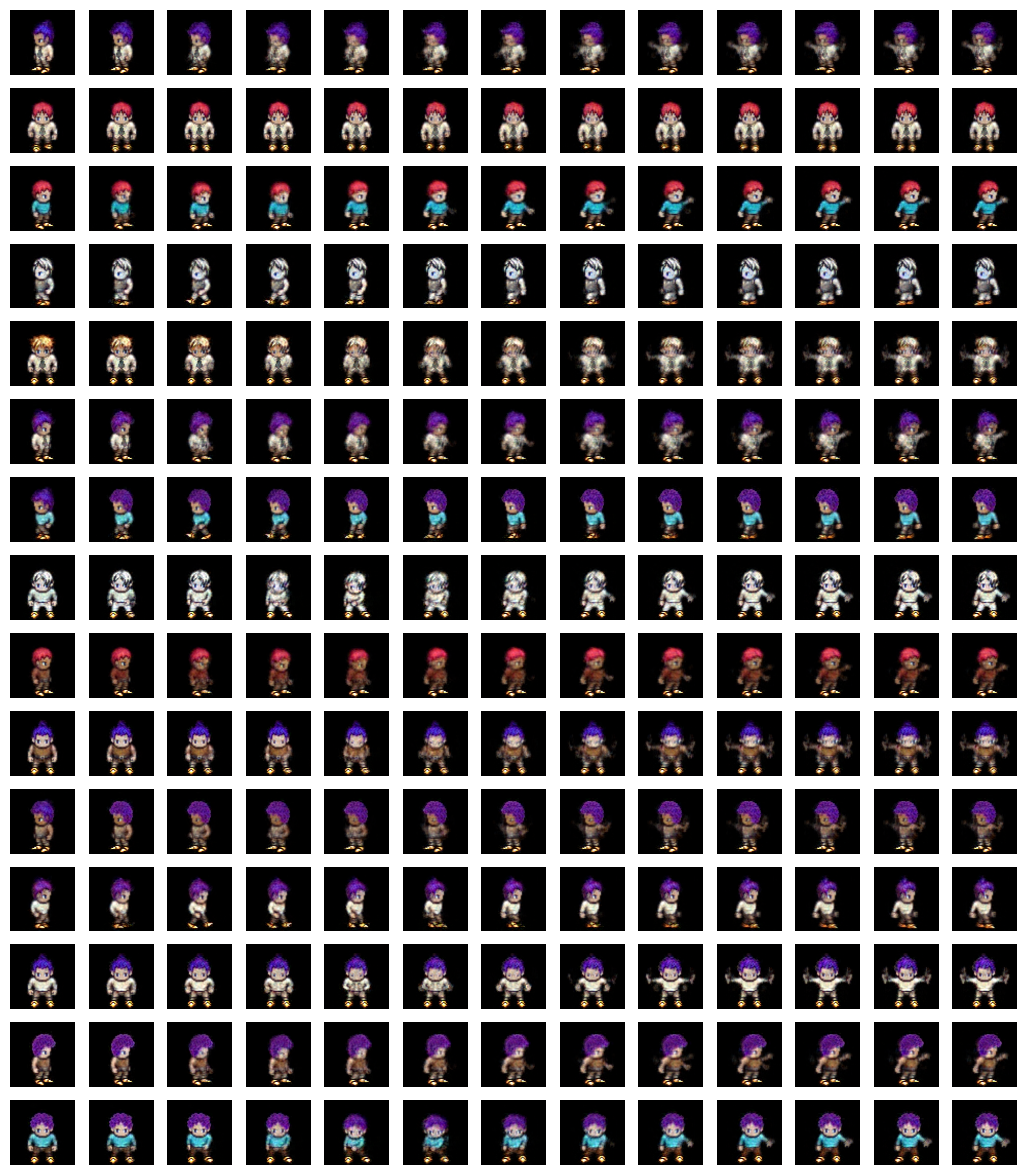

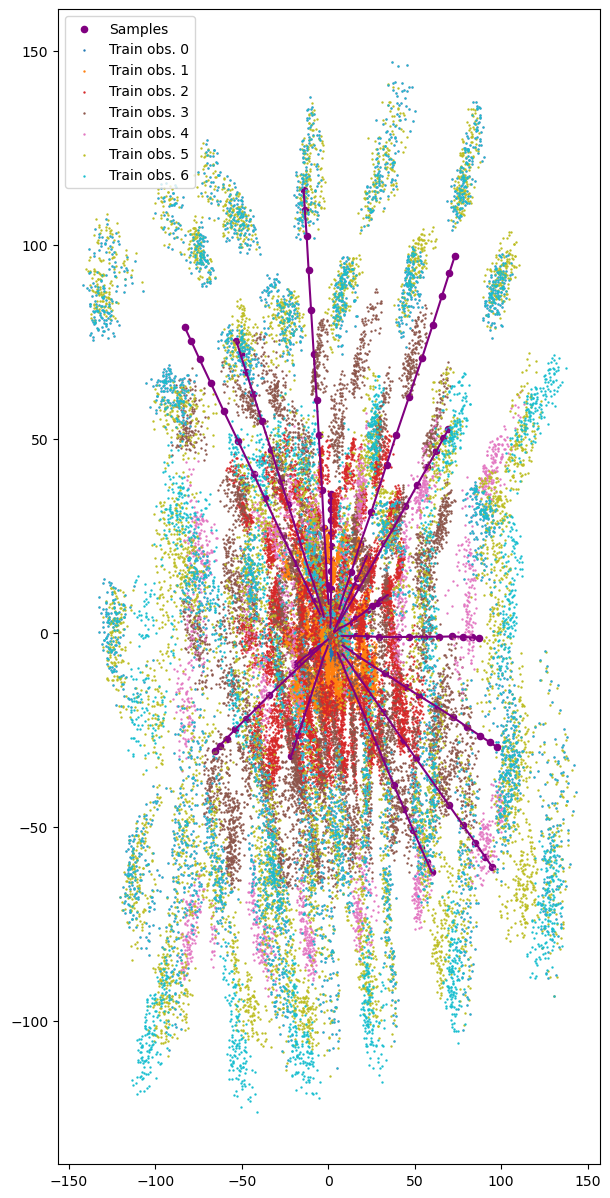

In [24]:
time_steps = np.sort([997, 831, 665, 499, 333, 167,   1] + [914, 748, 560, 416, 250, 84])
sampler = DDIMSampler(diffusion, time_steps=time_steps, ddim_eta=0.5)

lldm.ddim_sampler = sampler
lldm.n_obs = len(lldm.ddim_sampler.time_steps)
lldm.diff_t_steps = np.flip(lldm.ddim_sampler.time_steps)
print('Diffusion time steps ', lldm.diff_t_steps)
lldm.temperature = 0.5
recon_x, z_seq = lldm.generate(train_data, num_gen_seq=15, vi_index =0, T_multiplier = 1)

plot_sequence(recon_x)
plot_z_seqs(z_seq, train_embeddings)

## Sampling time

In [18]:
import time
num_gen_seqs = [10, 100, 200, 250, 300]
times_lldm, times_lvae, times_gpvae = [], [], []

for num_gen_seq in num_gen_seqs:
    start_time = time.time()
    recon_x, z_seq = lldm.generate(train_data, num_gen_seq=num_gen_seq, vi_index =3, T_multiplier = 1, verbose=False)
    end_time = time.time()
    print(f'Num gen seq: {num_gen_seq}, Time LLDM: {end_time - start_time}')
    times_lldm.append(end_time - start_time)

    start_time = time.time()
    recon_x_lvae, z_seq_lvae = lvae.generate(train_data, random_normal=True, num_gen_seq=num_gen_seq, vi_index = 0, T_multiplier = 1, verbose=False)
    end_time = time.time()
    times_lvae.append(end_time - start_time)
    print(f'Num gen seq: {num_gen_seq}, Time LVAE: {end_time - start_time}')

    start_time = time.time()
    recon_x_gpvae = gpvae.generate(num_gen_seq, device = 'cpu')
    end_time = time.time()
    times_gpvae.append(end_time - start_time)
    print(f'Num gen seq: {num_gen_seq}, Time GPVAE: {end_time - start_time}')
    

Num gen seq: 10, Time LLDM: 1.5655183792114258
Num gen seq: 10, Time LVAE: 0.010178327560424805
Num gen seq: 10, Time GPVAE: 0.025822162628173828
Num gen seq: 100, Time LLDM: 2.085522413253784
Num gen seq: 100, Time LVAE: 0.03613090515136719
Num gen seq: 100, Time GPVAE: 0.19695305824279785
Num gen seq: 200, Time LLDM: 3.4104409217834473
Num gen seq: 200, Time LVAE: 0.07046151161193848
Num gen seq: 200, Time GPVAE: 0.3887042999267578
Num gen seq: 250, Time LLDM: 3.883924722671509
Num gen seq: 250, Time LVAE: 0.08458399772644043
Num gen seq: 250, Time GPVAE: 0.5087404251098633
Num gen seq: 300, Time LLDM: 4.795875310897827
Num gen seq: 300, Time LVAE: 0.10535001754760742
Num gen seq: 300, Time GPVAE: 0.6086025238037109


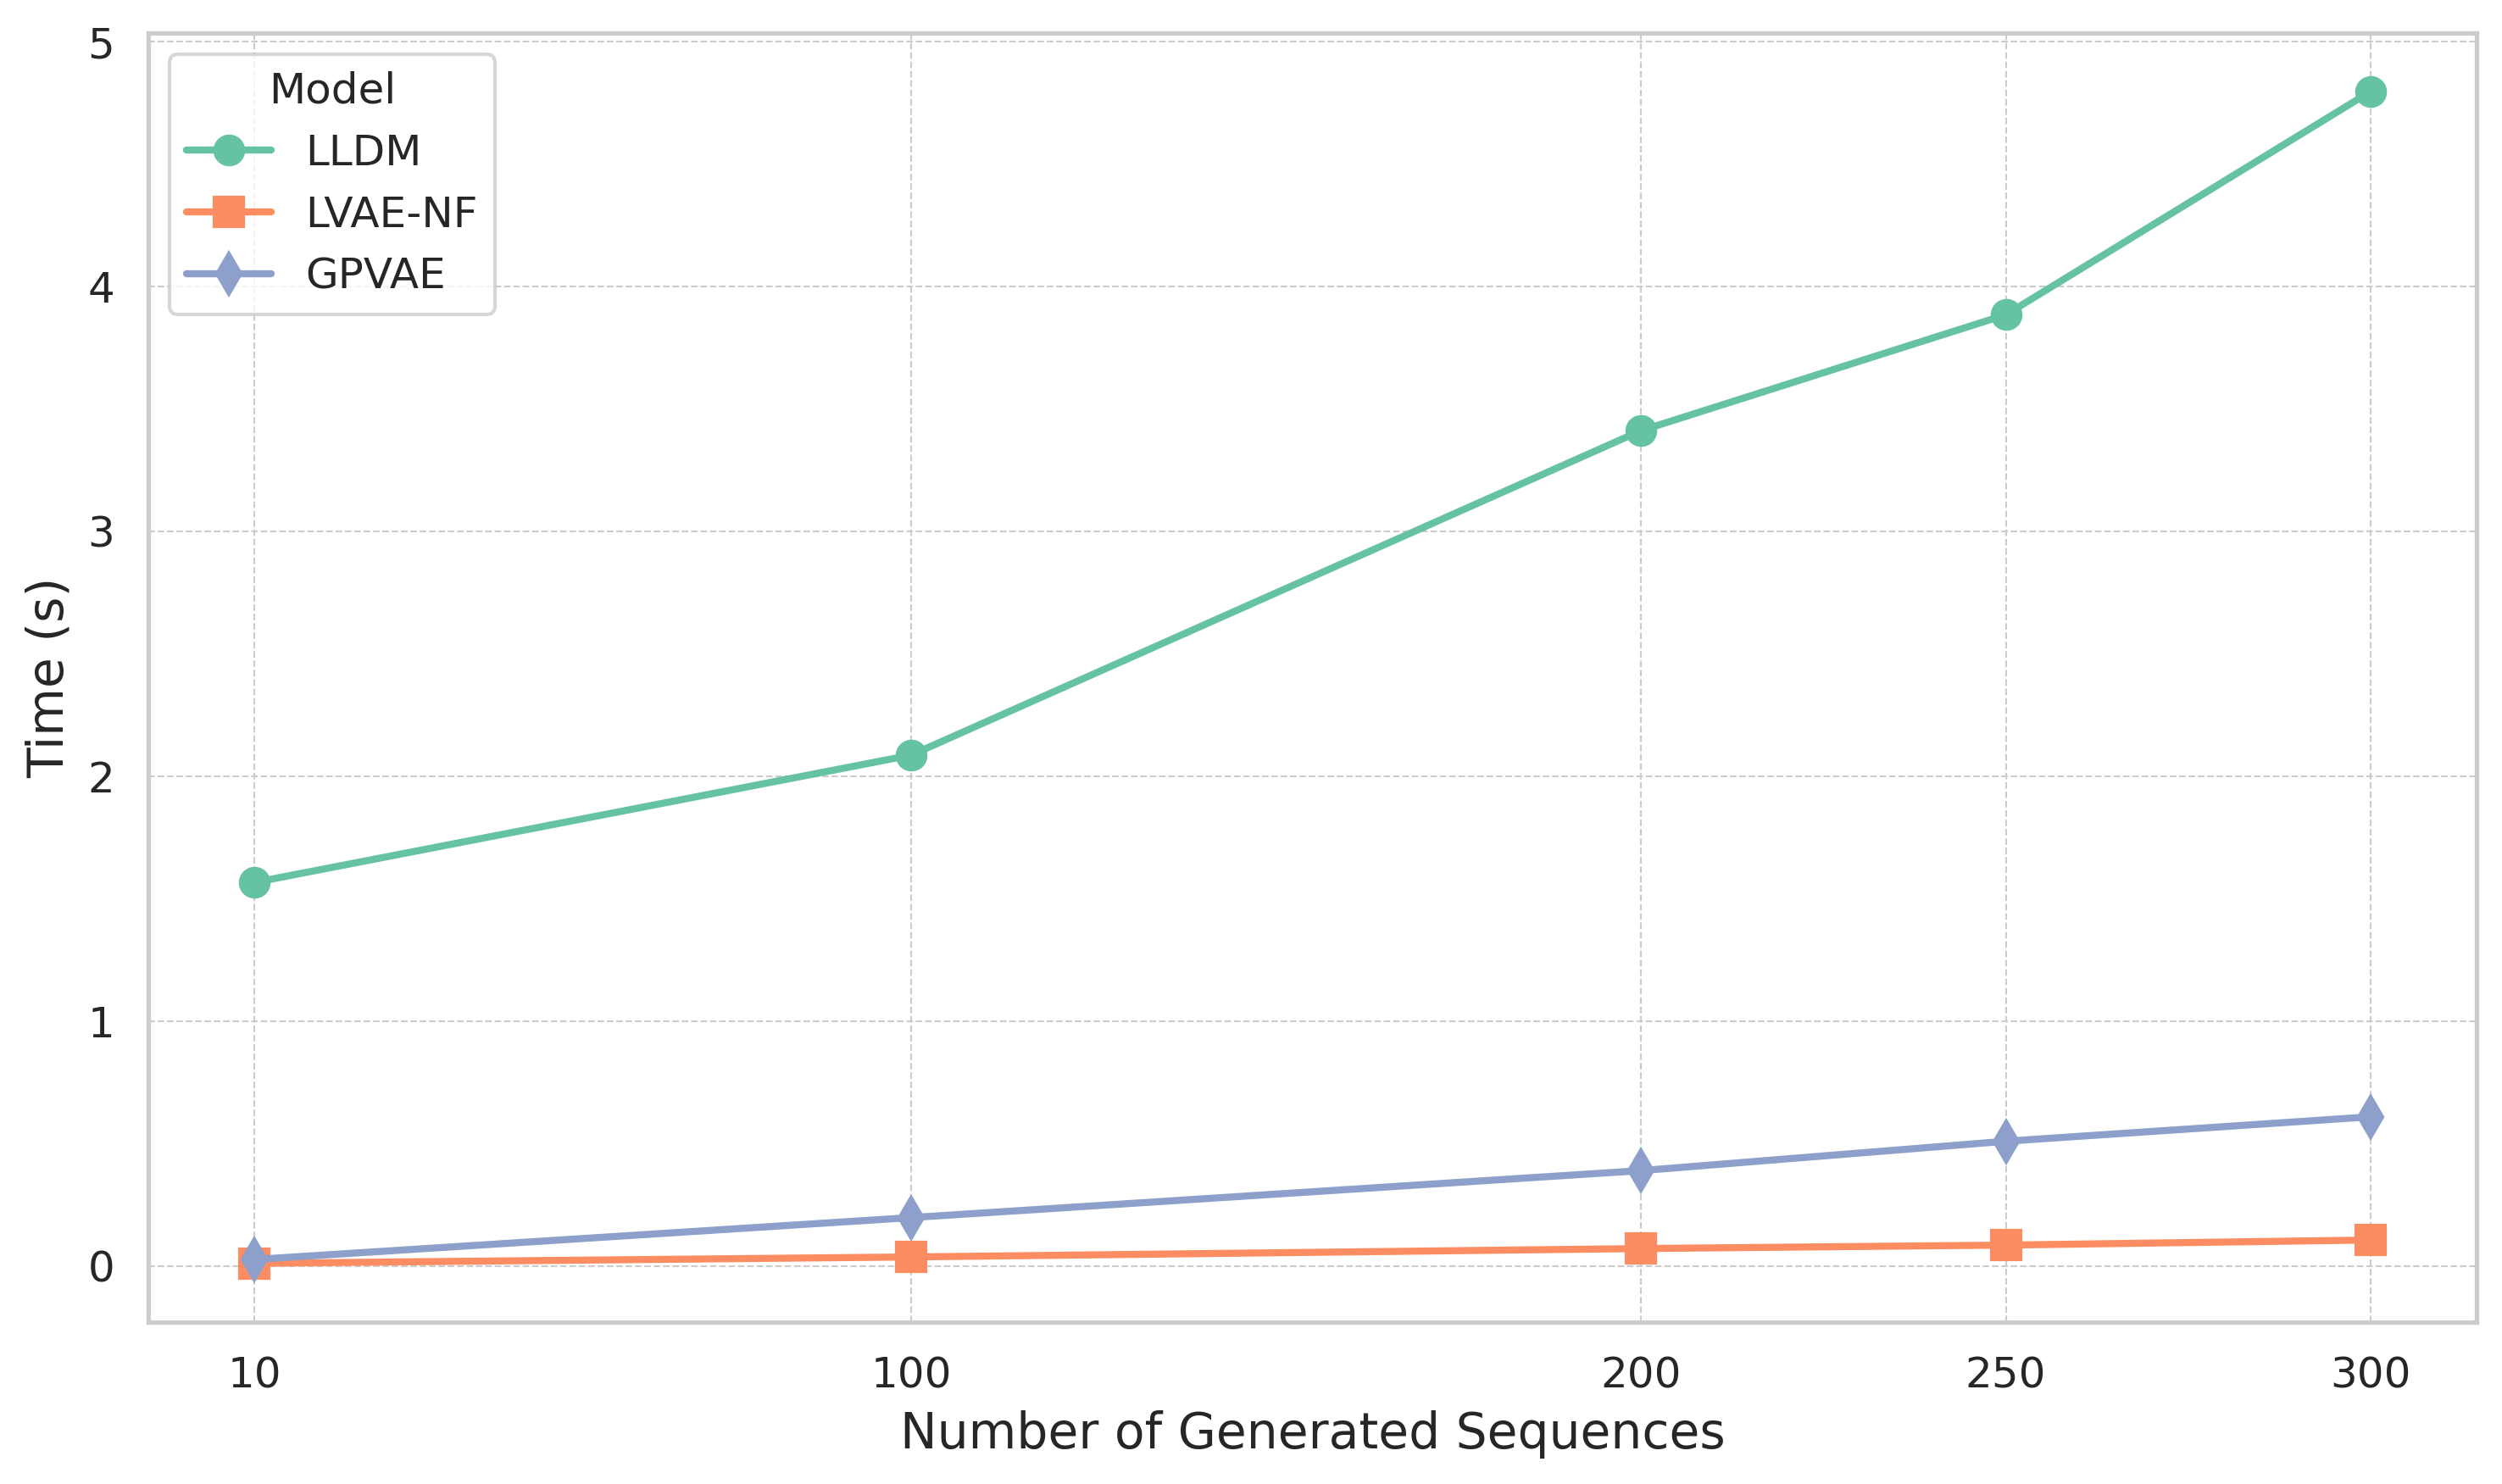

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size and resolution
plt.figure(figsize=(10, 6), dpi=300)

# Set aesthetic style and color palette
sns.set_theme(style='whitegrid', palette='Set2')

# Plot data with improved markers and line style
plt.plot(num_gen_seqs, times_lldm, label='LLDM', marker='o', linestyle='-', markersize=8, linewidth=2)
plt.plot(num_gen_seqs, times_lvae, label='LVAE-NF', marker='s', linestyle='-', markersize=8, linewidth=2)
plt.plot(num_gen_seqs, times_gpvae, label='GPVAE', marker='d', linestyle='-', markersize=8, linewidth=2)

# Title and axis labels
#plt.title('Performance Comparison: LLDM vs LVAE', fontsize=16, weight='bold')
plt.xlabel('Number of Generated Sequences', fontsize=14)
plt.ylabel('Time (s)', fontsize=14)

# Customizing the ticks
plt.xticks(num_gen_seqs, fontsize=12)
plt.yticks(fontsize=12)

# Displaying the legend and adjusting its position
plt.legend(title='Model', title_fontsize=12, loc='upper left', fontsize=12)

# Show gridlines and subtle background grid
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()


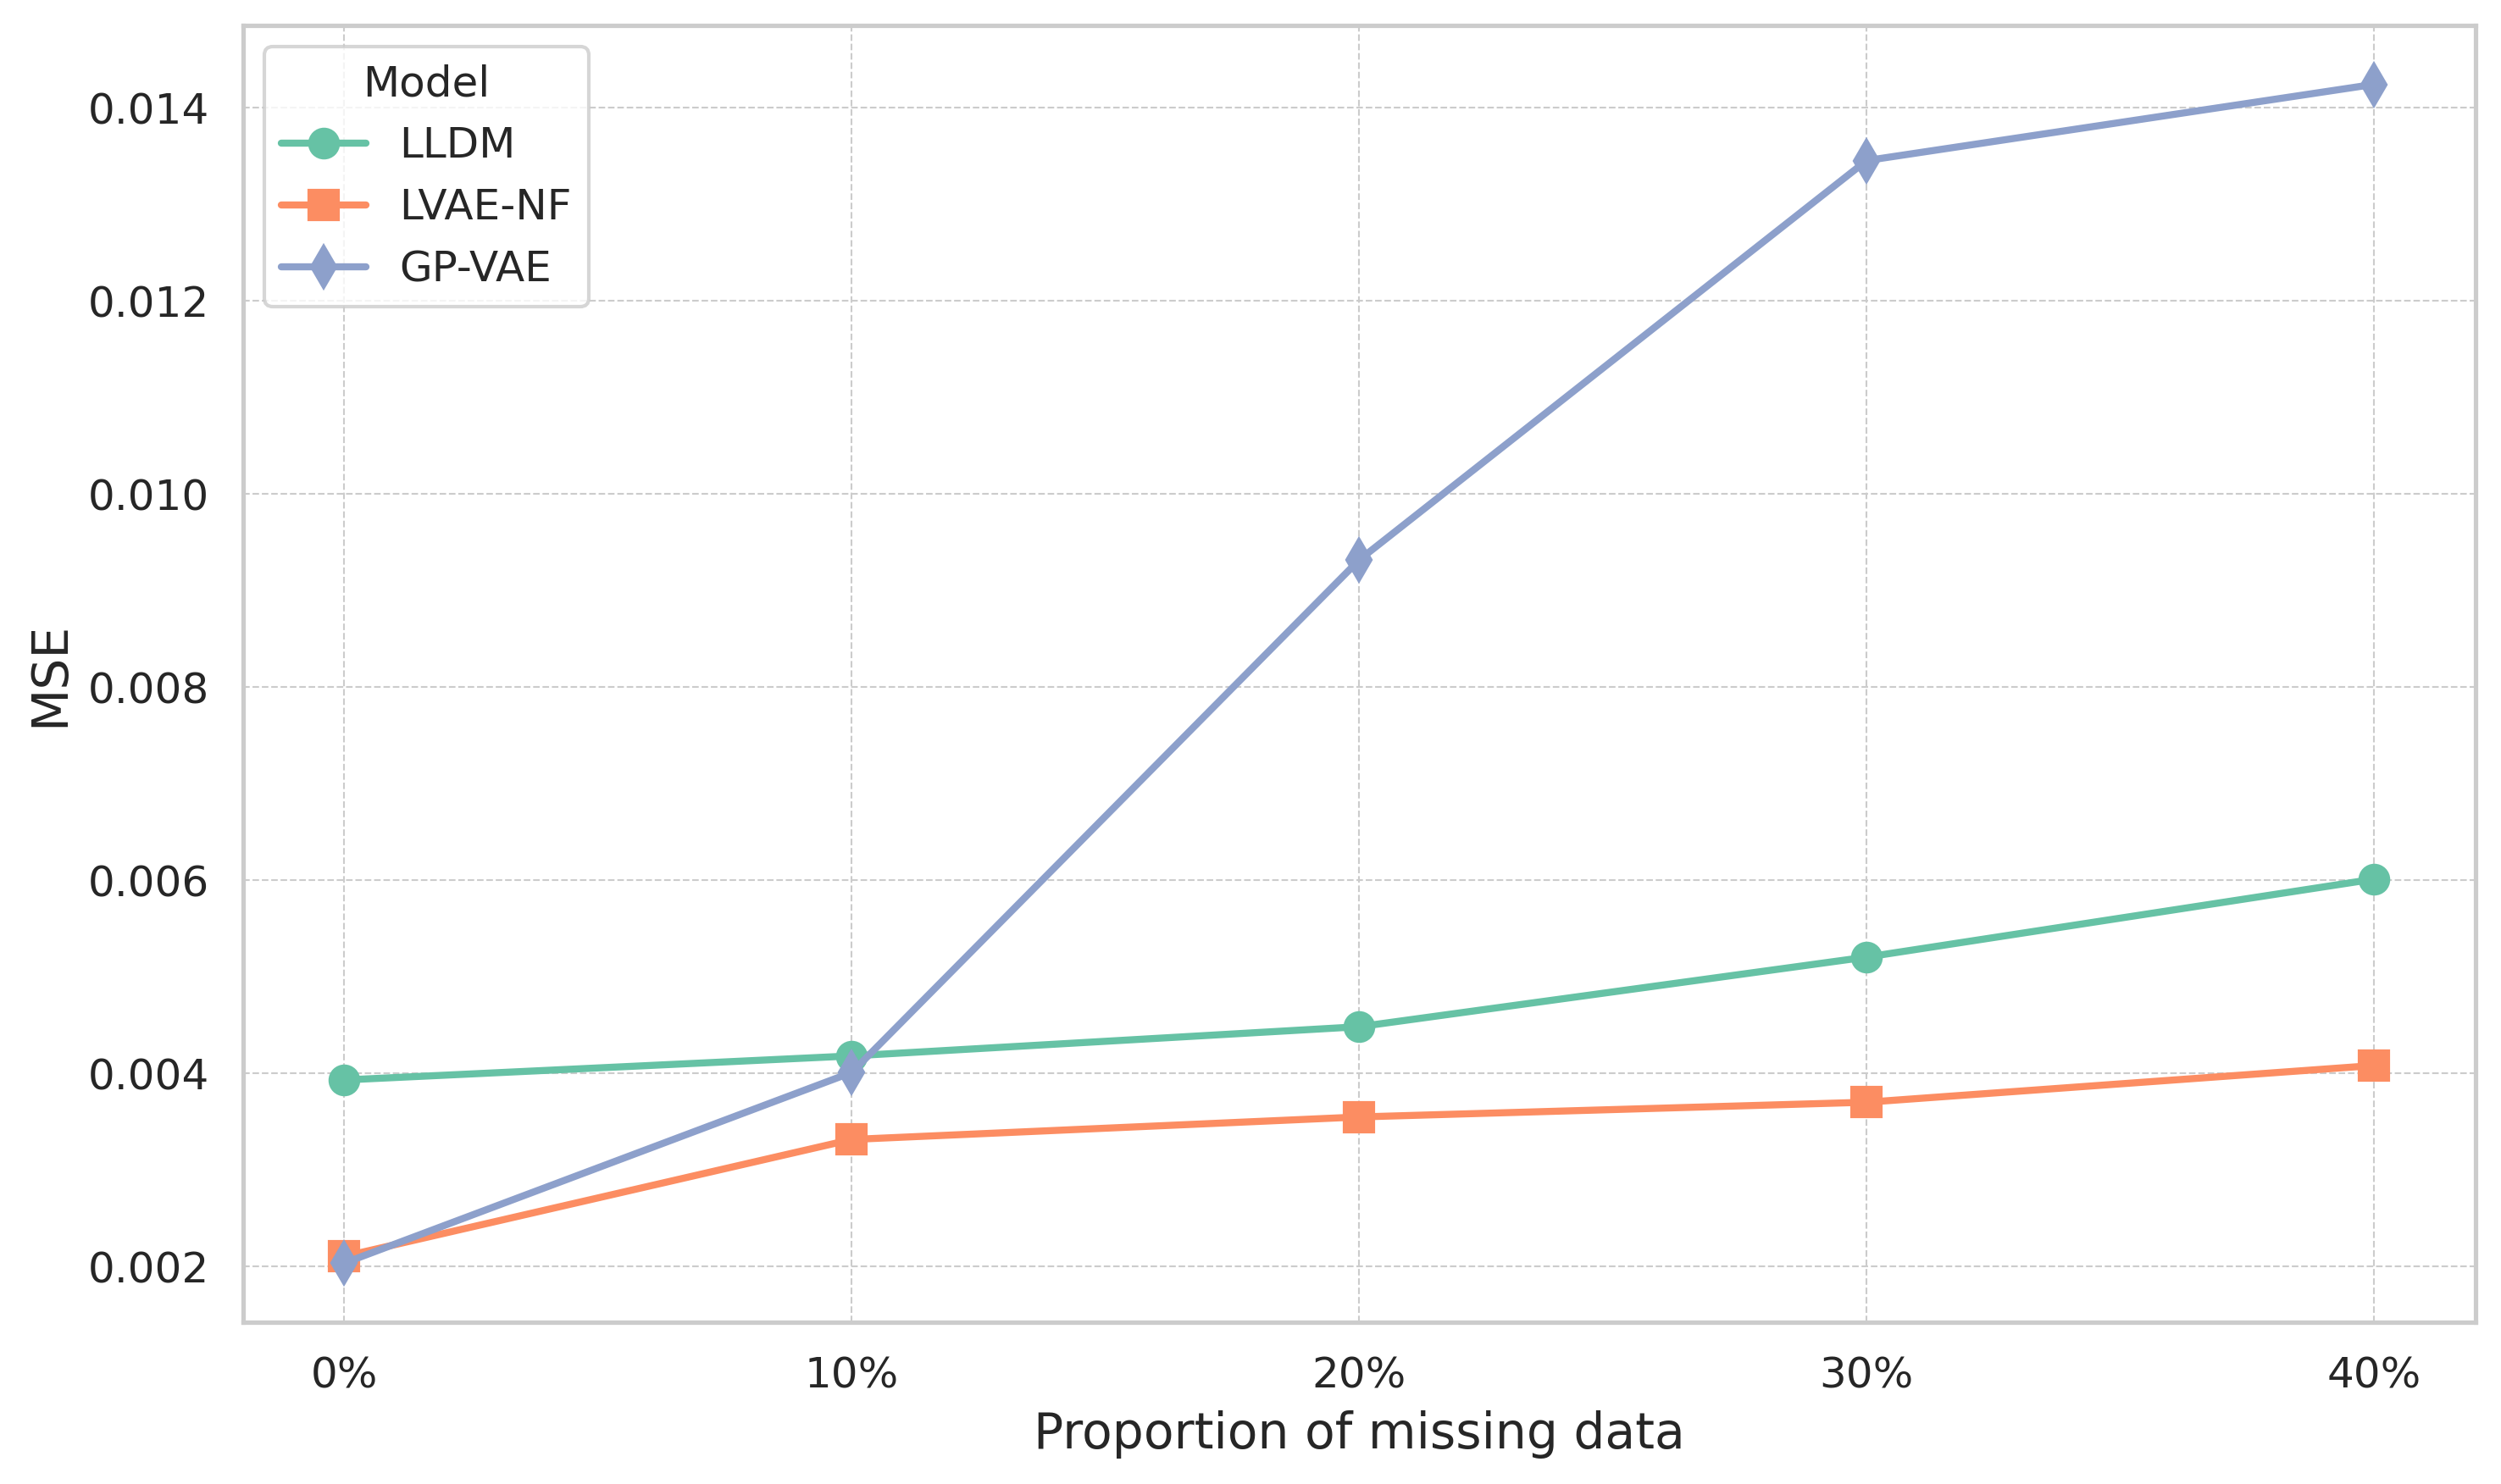

In [33]:
lvae_scores = [0.0021037247497588396, 0.003314302070066333, 0.0035474912729114294, 0.003700131317600608, 0.004080456215888262]
lldm_scores = [0.003930713515728712, 0.0041799829341471195, 0.0044824834913015366, 0.005203696899116039, 0.006011070683598518]
gpvae_scores = [0.002033791970461607, 0.004008693620562553, 0.009317790158092976, 0.013455068692564964, 0.014244241639971733]


import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size and resolution
plt.figure(figsize=(10, 6), dpi=300)

# Set aesthetic style and color palette
sns.set_theme(style='whitegrid', palette='Set2')

# Plot data with improved markers and line style
ticks = [0, 0.1, 0.2, 0.3, 0.4]
plt.plot(ticks, lldm_scores, label='LLDM', marker='o', linestyle='-', markersize=8, linewidth=2)
plt.plot(ticks, lvae_scores, label='LVAE-NF', marker='s', linestyle='-', markersize=8, linewidth=2)
plt.plot(ticks, gpvae_scores, label='GP-VAE', marker='d', linestyle='-', markersize=8, linewidth=2)

# Title and axis labels

plt.xlabel('Proportion of missing data', fontsize=14)
plt.ylabel('MSE', fontsize=14)

# Customizing the ticks
#percentage format for x-axis
plt.xticks(ticks, [f'{int(t*100)}%' for t in ticks], fontsize=12)
plt.yticks(fontsize=12)

# Displaying the legend and adjusting its position
plt.legend(title='Model', title_fontsize=12, loc='upper left', fontsize=12)

# Show gridlines and subtle background grid
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [34]:
disentagledvae = torch.load('DisentangledVAE.pth')